In [1]:
import rioxarray
import xarray
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib

In [2]:
prefix = '/scratch/tristate/'
region = 'UCSB'

In [3]:
path = f'{prefix}/{region}_results.zarr'
ds = xarray.open_zarr(path, mask_and_scale=True, consolidated=False)

path = f'{prefix}/{region}_cloudmask.zarr'
cloudmask = xarray.open_zarr(path, consolidated=False)['cloudmask']

path = f'{prefix}/{region}_sharp.zarr'
rgb = xarray.open_zarr(path, consolidated=False)['reflectance'].sel(band=['B4', 'B3', 'B2'])

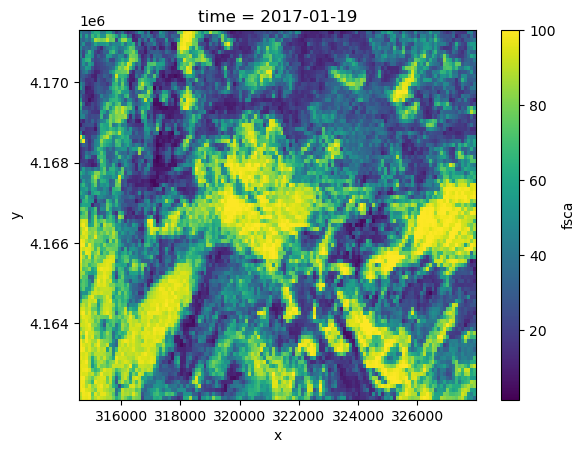

In [4]:
ds['fsca'].isel(time=20).coarsen(x=10, y=10, boundary='trim').mean().plot()

In [5]:
ds['cloudmask'] = cloudmask
ds['rgb'] = rgb

# Interpolating clouds and sharpening artifacts

- sharpening occasionally leaves holes. Probably N/A related

In [6]:
from dask.distributed import LocalCluster
import dask.distributed
import logging

dask.config.set({'temporary-directory': '/data/dask'})
dask.config.set({'distributed.comm.timeouts.tcp': '1200s'})
dask.config.set({'distributed.comm.timeouts.connect': '1200s'})
dask.config.get('distributed.comm.timeouts')

cluster = dask.distributed.LocalCluster(n_workers=32, 
                                        threads_per_worker=4, # Good question ... 
                                        memory_limit='64GB', 
                                        processes=True,  # Probably a good idea here
                                        dashboard_address='localhost:8787',
                                        silence_logs=logging.ERROR)

client = dask.distributed.Client(cluster) 

/home/griessban/.conda/envs/cloud/lib/python3.13/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42247 instead
  warnings.warn(


In [7]:
cloudmasked = xarray.where(ds['cloudmask']==0, ds[['fsca', 'fshade', 'grain_size', 'dust_concentration', 'rgb']], np.nan)
#cloudmasked = xarray.where(ds['cloudmask']==0, ds[['fsca', 'fshade']], np.nan)

In [8]:
cloudmasked['spatial_ref'] = ds['spatial_ref']

In [9]:
def prime_factors(n):
    factors = []
    divisor = 2
    while n > 1:
        if n % divisor == 0:
            factors.append(divisor)
            n //= divisor  # Use integer division
        else:
            divisor += 1
    return factors

In [10]:
prime_factors(len(ds.y))

[2, 2, 2, 5, 23]

## scipy:
`method` Specifies the kind of interpolation as a string or as an integer specifying the order of the spline interpolator to use. The string has to be one of ‘linear’, ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, or ‘next’. ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of zeroth, first, second or third order; ‘previous’ and ‘next’ simply return the previous or next value of the point; ‘nearest-up’ and ‘nearest’ differ when interpolating half-integers (e.g. 0.5, 1.5) in that ‘nearest-up’ rounds up and ‘nearest’ rounds down. Default is ‘linear’.

In [11]:
chunks_x = ds.chunks['x']
chunks_y = ds.chunks['y']
#chunks_x = 317
cloudmasked = cloudmasked.chunk(time=-1, y=chunks_y, x=chunks_x)

In [12]:
%%time
import datetime
max_gap = datetime.timedelta(days=14)
cloud_filled = cloudmasked.interpolate_na(dim="time", method="linear")#, max_gap=max_gap)

CPU times: user 45.4 ms, sys: 6.08 ms, total: 51.5 ms
Wall time: 47.1 ms


In [13]:
cloud_filled = cloud_filled.chunk(time=1, y=chunks_y, x=chunks_x)

In [14]:
cloud_filled

<xarray.Dataset> Size: 21GB
Dimensions:             (y: 920, time: 614, x: 1346, band: 3)
Coordinates:
  * y                   (y) float64 7kB 4.171e+06 4.171e+06 ... 4.162e+06
  * time                (time) datetime64[ns] 5kB 2015-10-07 ... 2025-10-29
  * x                   (x) float64 11kB 3.146e+05 3.146e+05 ... 3.28e+05
  * band                (band) object 24B 'B4' 'B3' 'B2'
Data variables:
    fsca                (time, y, x) float32 3GB dask.array<chunksize=(1, 920, 1346), meta=np.ndarray>
    fshade              (time, y, x) float32 3GB dask.array<chunksize=(1, 920, 1346), meta=np.ndarray>
    grain_size          (time, y, x) float32 3GB dask.array<chunksize=(1, 920, 1346), meta=np.ndarray>
    dust_concentration  (time, y, x) float32 3GB dask.array<chunksize=(1, 920, 1346), meta=np.ndarray>
    rgb                 (time, y, x, band) float32 9GB dask.array<chunksize=(1, 920, 1346, 3), meta=np.ndarray>
    spatial_ref         int64 8B ...

# Plot

In [15]:
colors = [
    (0, 0, 0, 0),        # Clear -> transparent
    (0xfd/255, 0xe0/255, 0xdd/255, 0.6),  # Thick Cloud
    (0xfa/255, 0x9f/255, 0xb5/255, 0.6),  # Thin Cloud
    (0xc5/255, 0x1b/255, 0x8a/255, 0.6)   # Cloud Shadow
]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=len(colors))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1573559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1573559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1573559].


2022-05-13T00:00:00.000000000


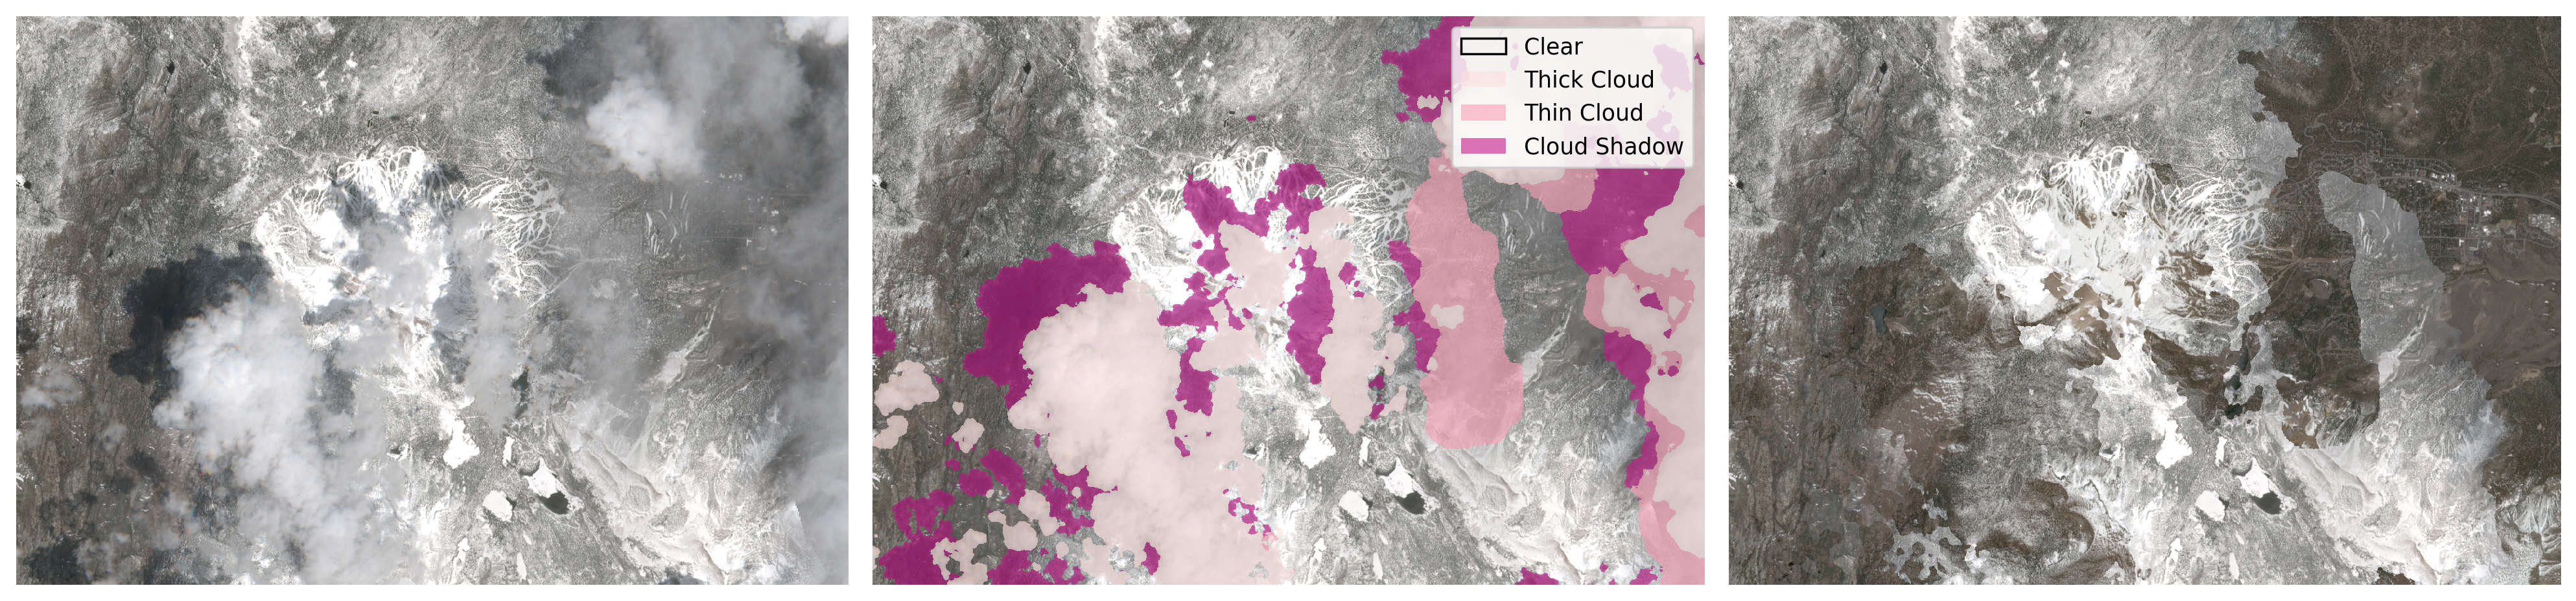

In [22]:
timestep = 367

fig, axs = plt.subplots(figsize=(16, 9), dpi=250, nrows=1, ncols=3)
ts_original = ds.isel(time=timestep).compute()
ts_cloudmasked = cloudmasked.isel(time=timestep)
ts_cloudfilled = cloud_filled.isel(time=timestep)

gamma = 2.2

(xarray.where(ts_original['rgb']<0, 0, ts_original['rgb'])**(1/gamma)).plot.imshow(ax=axs[0])
(xarray.where(ts_original['rgb']<0, 0, ts_original['rgb'])**(1/gamma)).plot.imshow(ax=axs[1])
ts_original['cloudmask'].plot.imshow(ax=axs[1], cmap=cmap, norm=norm, alpha=1, add_colorbar=False)
(xarray.where(ts_cloudfilled['rgb']<0, 0, ts_cloudfilled['rgb'])**(1/gamma)).plot.imshow(ax=axs[2])

legend_elements = [
    matplotlib.patches.Patch(facecolor='none', edgecolor='black', label='Clear'),
    matplotlib.patches.Patch(facecolor=colors[1], label='Thick Cloud'),
    matplotlib.patches.Patch(facecolor=colors[2], label='Thin Cloud'),
    matplotlib.patches.Patch(facecolor=colors[3], label='Cloud Shadow')
]
axs[1].legend(handles=legend_elements, loc='upper right')

for ax in axs:
    ax.set_aspect('equal')
    ax.axis('off')
    ax.title.set_visible(False)
fig.tight_layout()

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

print(ds['time'].isel(time=timestep).values)

In [23]:
fig.savefig('cloudfilled.png')

# Fix shade
```
ifsca=ifsca./(1-fshade-A.fice-A.cc);
ifsca(ifsca>1 | ifsca<0)=1;
```

Todo:
- [ ] Filter fsca==0 to prevent divide-by-zero

In [ ]:
shade_non100  = xarray.where(cloud_filled['fshade'] == 100, np.nan, cloud_filled['fshade'])
ifsca = (cloud_filled['fsca'] / (100 - shade_non100)) * 100
ifsca = xarray.where((abs(ifsca)>100) | (ifsca<0), 100, ifsca)
ifsca = xarray.where(cloud_filled['fshade']==100, 0, ifsca)

In [ ]:
timestep = 111

fig, axs = plt.subplots(figsize=(16, 9), dpi=250, nrows=2)
ts_cloudfilled = cloud_filled.isel(time=timestep)

ts_cloudfilled['fsca'].plot(ax=axs[0])
ifsca.isel(time=timestep).plot(ax=axs[1])
    
for ax in axs:
    ax.set_aspect('equal')
    ax.axis('off')
    ax.title.set_visible(False)
fig.tight_layout()

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

date = ds['time'].isel(time=timestep).dt.strftime('%Y-%m-%d').values
print(date)

In [ ]:
cloud_filled['fsca'] = ifsca

# Type conversion

In [ ]:
fill_value = -1

In [ ]:
cloud_filled['fsca'] = xarray.where(np.isnan(cloud_filled['fsca']), fill_value, cloud_filled['fsca']).astype(np.int8)
cloud_filled['fshade'] = xarray.where(np.isnan(cloud_filled['fshade']), fill_value, cloud_filled['fshade']).astype(np.int8)

In [ ]:
cloud_filled['fsca'].attrs["_FillValue"] = fill_value
cloud_filled['fshade'].attrs["_FillValue"] = fill_value

In [ ]:
cloud_filled

# Store

In [ ]:
%%time
cloud_filled.to_zarr(f'/data/sentinel2/zarrs_v3/{region}_postprocessed.zarr/', mode='w', consolidated=False)

In [ ]:
client.close()
cluster.close()

In [ ]:
1